## 範例重點

了解如何在 Keras 中，加入 regularization

熟悉建立、訓練模型

熟悉將訓練結果視覺化並比較結果

In [1]:
import keras
import os

# GPU 
os.environ["CUDA_VISIBLE_DEVICES"] = "0"

Using TensorFlow backend.


In [2]:
# 從 Keras 的內建功能中，取得 train 與 test 資料集
train, test = keras.datasets.cifar10.load_data()

In [3]:
## 資料前處理
def preproc_x(x, flatten=True):
    x = x / 255.
    if flatten:
        x = x.reshape((len(x), -1))
    return x

def preproc_y(y, num_classes=10):
    if y.shape[-1] == 1:
        y = keras.utils.to_categorical(y, num_classes)
    return y    

In [4]:
x_train, y_train = train
x_test, y_test = test

# 資料前處理 - X 標準化
x_train = preproc_x(x_train)
x_test = preproc_x(x_test)

# 資料前處理 -Y 轉成 onehot
y_train = preproc_y(y_train)
y_test = preproc_y(y_test)

In [5]:
from keras.regularizers import l1, l2, l1_l2

"""
建立神經網路，並加入 L1 或 L2
"""
def build_mlp(input_shape, output_units=10, num_neurons=[512, 256, 128], l2_ratio=1e-4):
    
    input_layer = keras.layers.Input(input_shape)
    
    for i, n_units in enumerate(num_neurons):
        if i == 0:
            x = keras.layers.Dense(units=n_units, 
                                   activation="relu", 
                                   name="hidden_layer"+str(i+1), 
                                   kernel_regularizer=l2(l2_ratio))(input_layer) # regularization
        else:
            x = keras.layers.Dense(units=n_units, 
                                   activation="relu", 
                                   name="hidden_layer"+str(i+1),
                                   kernel_regularizer=l2(l2_ratio))(x) # regularization
    
    out = keras.layers.Dense(units=output_units, activation="softmax", name="output")(x)
    
    model = keras.models.Model(inputs=[input_layer], outputs=[out])
    return model

In [6]:
## 超參數設定
LEARNING_RATE = 1e-3
EPOCHS = 50
BATCH_SIZE = 256
MOMENTUM = 0.95
L2_EXP = [1e-2, 1e-4, 1e-8, 1e-12]

In [7]:
results = {}
"""
使用迴圈建立不同的帶不同 L1/L2 的模型並訓練
"""
for regulizer_ratio in L2_EXP:
    keras.backend.clear_session() # 把舊的 Graph 清掉
    print("Experiment with Regulizer = %.6f" % (regulizer_ratio))
    model = build_mlp(input_shape=x_train.shape[1:], l2_ratio=regulizer_ratio)
    model.summary()
    optimizer = keras.optimizers.SGD(lr=LEARNING_RATE, nesterov=True, momentum=MOMENTUM)
    model.compile(loss="categorical_crossentropy", metrics=["accuracy"], optimizer=optimizer)

    model.fit(x_train, y_train, 
              epochs=EPOCHS, 
              batch_size=BATCH_SIZE, 
              validation_data=(x_test, y_test), 
              shuffle=True)
    
    # Collect results
    train_loss = model.history.history["loss"]
    valid_loss = model.history.history["val_loss"]
    train_acc = model.history.history["acc"]
    valid_acc = model.history.history["val_acc"]
    
    exp_name_tag = "exp-l2-%s" % str(regulizer_ratio)
    results[exp_name_tag] = {'train-loss': train_loss,
                             'valid-loss': valid_loss,
                             'train-acc': train_acc,
                             'valid-acc': valid_acc}

W0721 20:08:18.172437 4647654848 deprecation_wrapper.py:119] From /Users/johnsonhuang/anaconda3/envs/tensorflow/lib/python3.6/site-packages/keras/backend/tensorflow_backend.py:95: The name tf.reset_default_graph is deprecated. Please use tf.compat.v1.reset_default_graph instead.

W0721 20:08:18.199876 4647654848 deprecation_wrapper.py:119] From /Users/johnsonhuang/anaconda3/envs/tensorflow/lib/python3.6/site-packages/keras/backend/tensorflow_backend.py:98: The name tf.placeholder_with_default is deprecated. Please use tf.compat.v1.placeholder_with_default instead.

W0721 20:08:18.322386 4647654848 deprecation_wrapper.py:119] From /Users/johnsonhuang/anaconda3/envs/tensorflow/lib/python3.6/site-packages/keras/backend/tensorflow_backend.py:102: The name tf.get_default_graph is deprecated. Please use tf.compat.v1.get_default_graph instead.

W0721 20:08:18.331336 4647654848 deprecation_wrapper.py:119] From /Users/johnsonhuang/anaconda3/envs/tensorflow/lib/python3.6/site-packages/keras/back

Experiment with Regulizer = 0.010000
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_1 (InputLayer)         (None, 3072)              0         
_________________________________________________________________
hidden_layer1 (Dense)        (None, 512)               1573376   
_________________________________________________________________
hidden_layer2 (Dense)        (None, 256)               131328    
_________________________________________________________________
hidden_layer3 (Dense)        (None, 128)               32896     
_________________________________________________________________
output (Dense)               (None, 10)                1290      
Total params: 1,738,890
Trainable params: 1,738,890
Non-trainable params: 0
_________________________________________________________________


W0721 20:08:18.697165 4647654848 deprecation.py:323] From /Users/johnsonhuang/anaconda3/envs/tensorflow/lib/python3.6/site-packages/tensorflow/python/ops/math_grad.py:1250: add_dispatch_support.<locals>.wrapper (from tensorflow.python.ops.array_ops) is deprecated and will be removed in a future version.
Instructions for updating:
Use tf.where in 2.0, which has the same broadcast rule as np.where


Train on 50000 samples, validate on 10000 samples
Epoch 1/50
50000/50000 [==============================] - 23s 458us/step - loss: 15.1055 - acc: 0.2654 - val_loss: 13.9793 - val_acc: 0.3351
Epoch 2/50
50000/50000 [==============================] - 12s 242us/step - loss: 13.0354 - acc: 0.3554 - val_loss: 12.1360 - val_acc: 0.3761
Epoch 3/50
50000/50000 [==============================] - 10s 201us/step - loss: 11.3563 - acc: 0.3797 - val_loss: 10.6088 - val_acc: 0.3867
Epoch 4/50
50000/50000 [==============================] - 8s 168us/step - loss: 9.9403 - acc: 0.3966 - val_loss: 9.3039 - val_acc: 0.4031
Epoch 5/50
50000/50000 [==============================] - 8s 156us/step - loss: 8.7375 - acc: 0.4059 - val_loss: 8.1943 - val_acc: 0.4099
Epoch 6/50
50000/50000 [==============================] - 7s 148us/step - loss: 7.7129 - acc: 0.4167 - val_loss: 7.2488 - val_acc: 0.4207
Epoch 7/50
50000/50000 [==============================] - 7s 143us/step - loss: 6.8402 - acc: 0.4219 - val_loss: 

50000/50000 [==============================] - 11s 220us/step - loss: 2.2048 - acc: 0.2618 - val_loss: 2.0350 - val_acc: 0.3369
Epoch 2/50
50000/50000 [==============================] - 11s 215us/step - loss: 1.9746 - acc: 0.3563 - val_loss: 1.9262 - val_acc: 0.3665
Epoch 3/50
50000/50000 [==============================] - 10s 195us/step - loss: 1.8891 - acc: 0.3867 - val_loss: 1.8675 - val_acc: 0.3878
Epoch 4/50
50000/50000 [==============================] - 11s 212us/step - loss: 1.8314 - acc: 0.4088 - val_loss: 1.8014 - val_acc: 0.4168
Epoch 5/50
50000/50000 [==============================] - 10s 193us/step - loss: 1.7815 - acc: 0.4258 - val_loss: 1.7726 - val_acc: 0.4239
Epoch 6/50
50000/50000 [==============================] - 9s 172us/step - loss: 1.7428 - acc: 0.4390 - val_loss: 1.7322 - val_acc: 0.4430
Epoch 7/50
50000/50000 [==============================] - 9s 182us/step - loss: 1.7078 - acc: 0.4521 - val_loss: 1.7050 - val_acc: 0.4499
Epoch 8/50
50000/50000 [================

/Users/johnsonhuang/anaconda3/envs/tensorflow/lib/python3.6/site-packages/keras/callbacks.py:122: UserWarning: Method on_batch_end() is slow compared to the batch update (0.113644). Check your callbacks.
  % delta_t_median)


50000/50000 [==============================] - 17s 333us/step - loss: 1.0551 - acc: 0.6783 - val_loss: 1.5437 - val_acc: 0.5236
Epoch 50/50
50000/50000 [==============================] - 19s 380us/step - loss: 1.0427 - acc: 0.6812 - val_loss: 1.5964 - val_acc: 0.5167
Experiment with Regulizer = 0.000000
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_1 (InputLayer)         (None, 3072)              0         
_________________________________________________________________
hidden_layer1 (Dense)        (None, 512)               1573376   
_________________________________________________________________
hidden_layer2 (Dense)        (None, 256)               131328    
_________________________________________________________________
hidden_layer3 (Dense)        (None, 128)               32896     
_________________________________________________________________
output (Dense)               (None,

Epoch 50/50
50000/50000 [==============================] - 37s 735us/step - loss: 0.8776 - acc: 0.6941 - val_loss: 1.4613 - val_acc: 0.5196
Experiment with Regulizer = 0.000000
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_1 (InputLayer)         (None, 3072)              0         
_________________________________________________________________
hidden_layer1 (Dense)        (None, 512)               1573376   
_________________________________________________________________
hidden_layer2 (Dense)        (None, 256)               131328    
_________________________________________________________________
hidden_layer3 (Dense)        (None, 128)               32896     
_________________________________________________________________
output (Dense)               (None, 10)                1290      
Total params: 1,738,890
Trainable params: 1,738,890
Non-trainable params: 0
_____________________

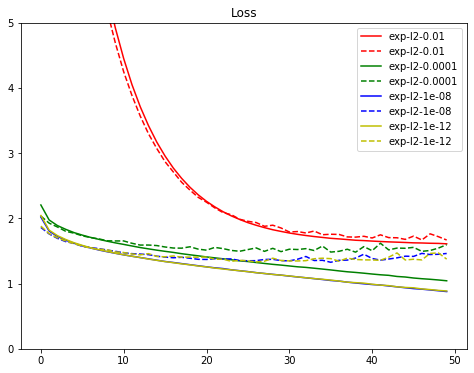

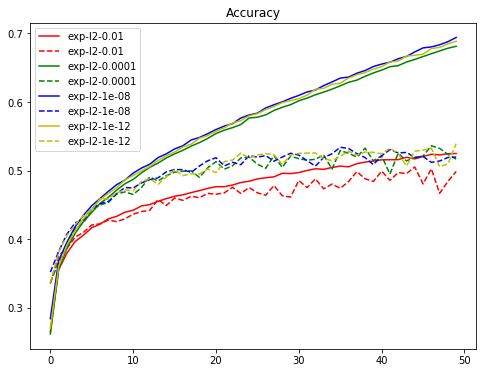

In [8]:
import matplotlib.pyplot as plt
%matplotlib inline
color_bar = ["r", "g", "b", "y", "m", "k"]

plt.figure(figsize=(8,6))
for i, cond in enumerate(results.keys()):
    plt.plot(range(len(results[cond]['train-loss'])),results[cond]['train-loss'], '-', label=cond, color=color_bar[i])
    plt.plot(range(len(results[cond]['valid-loss'])),results[cond]['valid-loss'], '--', label=cond, color=color_bar[i])
plt.title("Loss")
plt.ylim([0, 5])
plt.legend()
plt.show()

plt.figure(figsize=(8,6))
for i, cond in enumerate(results.keys()):
    plt.plot(range(len(results[cond]['train-acc'])),results[cond]['train-acc'], '-', label=cond, color=color_bar[i])
    plt.plot(range(len(results[cond]['valid-acc'])),results[cond]['valid-acc'], '--', label=cond, color=color_bar[i])
plt.title("Accuracy")
plt.legend()
plt.show()


## Work

1. 請比較使用 l1, l1_l2 及不同比例下的訓練結果

In [9]:
import os
import keras

# Disable GPU
os.environ["CUDA_VISIBLE_DEVICES"] = "0"

Experiment with Regulizer = 0.010000
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_1 (InputLayer)         (None, 3072)              0         
_________________________________________________________________
hidden_layer1 (Dense)        (None, 512)               1573376   
_________________________________________________________________
hidden_layer2 (Dense)        (None, 256)               131328    
_________________________________________________________________
hidden_layer3 (Dense)        (None, 128)               32896     
_________________________________________________________________
output (Dense)               (None, 10)                1290      
Total params: 1,738,890
Trainable params: 1,738,890
Non-trainable params: 0
_________________________________________________________________
Train on 50000 samples, validate on 10000 samples
Epoch 1/50
50000/50000 [=====================

Train on 50000 samples, validate on 10000 samples
Epoch 1/50
50000/50000 [==============================] - 7s 140us/step - loss: 2.4635 - acc: 0.0957 - val_loss: 2.3036 - val_acc: 0.0997
Epoch 2/50
50000/50000 [==============================] - 7s 146us/step - loss: 2.3035 - acc: 0.0999 - val_loss: 2.3033 - val_acc: 0.1007
Epoch 3/50
50000/50000 [==============================] - 7s 144us/step - loss: 2.3032 - acc: 0.0975 - val_loss: 2.3031 - val_acc: 0.1008
Epoch 4/50
50000/50000 [==============================] - 7s 139us/step - loss: 2.3031 - acc: 0.0974 - val_loss: 2.3030 - val_acc: 0.1010
Epoch 5/50
50000/50000 [==============================] - 7s 143us/step - loss: 2.3030 - acc: 0.0973 - val_loss: 2.3030 - val_acc: 0.1006
Epoch 6/50
50000/50000 [==============================] - 7s 149us/step - loss: 2.3030 - acc: 0.0962 - val_loss: 2.3029 - val_acc: 0.1003
Epoch 7/50
50000/50000 [==============================] - 7s 147us/step - loss: 2.3029 - acc: 0.0998 - val_loss: 2.3029 - 

Epoch 2/50
50000/50000 [==============================] - 7s 149us/step - loss: 1.8078 - acc: 0.3679 - val_loss: 1.7582 - val_acc: 0.3881
Epoch 3/50
50000/50000 [==============================] - 8s 158us/step - loss: 1.7245 - acc: 0.3967 - val_loss: 1.7019 - val_acc: 0.3999
Epoch 4/50
50000/50000 [==============================] - 8s 162us/step - loss: 1.6686 - acc: 0.4158 - val_loss: 1.6475 - val_acc: 0.4243
Epoch 5/50
50000/50000 [==============================] - 8s 152us/step - loss: 1.6228 - acc: 0.4300 - val_loss: 1.6090 - val_acc: 0.4311
Epoch 6/50
50000/50000 [==============================] - 7s 146us/step - loss: 1.5834 - acc: 0.4448 - val_loss: 1.5757 - val_acc: 0.4466
Epoch 7/50
50000/50000 [==============================] - 7s 140us/step - loss: 1.5484 - acc: 0.4550 - val_loss: 1.5627 - val_acc: 0.4460- ETA: 0s - loss: 1.5499 - 
Epoch 8/50
50000/50000 [==============================] - 8s 152us/step - loss: 1.5191 - acc: 0.4668 - val_loss: 1.5336 - val_acc: 0.4566
Epoch 9

Epoch 3/50
50000/50000 [==============================] - 6s 122us/step - loss: 1.7141 - acc: 0.3990 - val_loss: 1.6852 - val_acc: 0.4095
Epoch 4/50
50000/50000 [==============================] - 7s 133us/step - loss: 1.6574 - acc: 0.4199 - val_loss: 1.6438 - val_acc: 0.4309
Epoch 5/50
50000/50000 [==============================] - 6s 117us/step - loss: 1.6111 - acc: 0.4353 - val_loss: 1.6043 - val_acc: 0.4369
Epoch 6/50
50000/50000 [==============================] - 6s 112us/step - loss: 1.5700 - acc: 0.4505 - val_loss: 1.5723 - val_acc: 0.4430
Epoch 7/50
50000/50000 [==============================] - 6s 119us/step - loss: 1.5375 - acc: 0.4610 - val_loss: 1.5361 - val_acc: 0.4627
Epoch 8/50
50000/50000 [==============================] - 5s 110us/step - loss: 1.5050 - acc: 0.4716 - val_loss: 1.5160 - val_acc: 0.4675
Epoch 9/50
50000/50000 [==============================] - 5s 109us/step - loss: 1.4779 - acc: 0.4816 - val_loss: 1.4880 - val_acc: 0.4778
Epoch 10/50
50000/50000 [=========

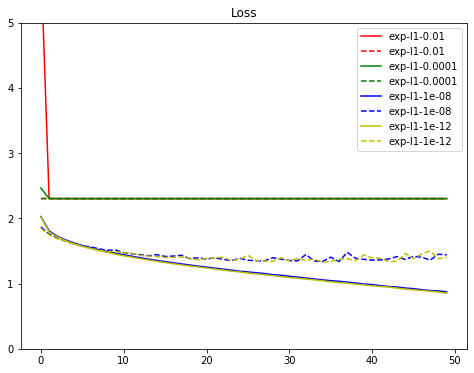

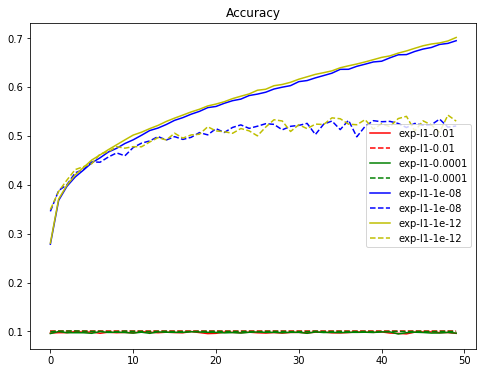

In [13]:
train, test = keras.datasets.cifar10.load_data()




## 資料前處理
def preproc_x(x, flatten=True):
    x = x / 255.
    if flatten:
        x = x.reshape((len(x), -1))
    return x

def preproc_y(y, num_classes=10):
    if y.shape[-1] == 1:
        y = keras.utils.to_categorical(y, num_classes)
    return y   




x_train, y_train = train
x_test, y_test = test

# Preproc the inputs
x_train = preproc_x(x_train)
x_test = preproc_x(x_test)

# Preprc the outputs
y_train = preproc_y(y_train)
y_test = preproc_y(y_test)




from keras.regularizers import l1, l2, l1_l2

"""
建立神經網路，並加入 L1 或 L2
"""
def build_mlp(input_shape, output_units=10, num_neurons=[512, 256, 128], l1_ratio=1e-4):
    
    input_layer = keras.layers.Input(input_shape)
    
    for i, n_units in enumerate(num_neurons):
        if i == 0:
            x = keras.layers.Dense(units=n_units, 
                                   activation="relu", 
                                   name="hidden_layer"+str(i+1), 
                                   activity_regularizer=l1(l1_ratio))(input_layer) # regularization
        else:
            x = keras.layers.Dense(units=n_units, 
                                   activation="relu", 
                                   name="hidden_layer"+str(i+1),
                                   activity_regularizer=l1(l1_ratio))(x) # regularization
    
    out = keras.layers.Dense(units=output_units, activation="softmax", name="output")(x)
    
    model = keras.models.Model(inputs=[input_layer], outputs=[out])
    return model




## 超參數設定
LEARNING_RATE = 1e-3
EPOCHS = 50
BATCH_SIZE = 256
MOMENTUM = 0.95
L1_EXP = [1e-2, 1e-4, 1e-8, 1e-12]




results = {}
"""
使用迴圈建立不同的帶不同 L1/L2 的模型並訓練
"""
for regulizer_ratio in L1_EXP:
    keras.backend.clear_session() # 把舊的 Graph 清掉
    print("Experiment with Regulizer = %.6f" % (regulizer_ratio))
    model = build_mlp(input_shape=x_train.shape[1:], l1_ratio=regulizer_ratio)
    model.summary()
    optimizer = keras.optimizers.SGD(lr=LEARNING_RATE, nesterov=True, momentum=MOMENTUM)
    model.compile(loss="categorical_crossentropy", metrics=["accuracy"], optimizer=optimizer)

    model.fit(x_train, y_train, 
              epochs=EPOCHS, 
              batch_size=BATCH_SIZE, 
              validation_data=(x_test, y_test), 
              shuffle=True)
    
    # Collect results
    train_loss = model.history.history["loss"]
    valid_loss = model.history.history["val_loss"]
    train_acc = model.history.history["acc"]
    valid_acc = model.history.history["val_acc"]
    
    exp_name_tag = "exp-l1-%s" % str(regulizer_ratio)
    results[exp_name_tag] = {'train-loss': train_loss,
                             'valid-loss': valid_loss,
                             'train-acc': train_acc,
                             'valid-acc': valid_acc}
    
    

import matplotlib.pyplot as plt
%matplotlib inline
color_bar = ["r", "g", "b", "y", "m", "k"]

plt.figure(figsize=(8,6))
for i, cond in enumerate(results.keys()):
    plt.plot(range(len(results[cond]['train-loss'])),results[cond]['train-loss'], '-', label=cond, color=color_bar[i])
    plt.plot(range(len(results[cond]['valid-loss'])),results[cond]['valid-loss'], '--', label=cond, color=color_bar[i])
plt.title("Loss")
plt.ylim([0, 5])
plt.legend()
plt.show()

plt.figure(figsize=(8,6))
for i, cond in enumerate(results.keys()):
    plt.plot(range(len(results[cond]['train-acc'])),results[cond]['train-acc'], '-', label=cond, color=color_bar[i])
    plt.plot(range(len(results[cond]['valid-acc'])),results[cond]['valid-acc'], '--', label=cond, color=color_bar[i])
plt.title("Accuracy")
plt.legend()
plt.show()

Experiment with Regulizer = 0.010000
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_1 (InputLayer)         (None, 3072)              0         
_________________________________________________________________
hidden_layer1 (Dense)        (None, 512)               1573376   
_________________________________________________________________
hidden_layer2 (Dense)        (None, 256)               131328    
_________________________________________________________________
hidden_layer3 (Dense)        (None, 128)               32896     
_________________________________________________________________
output (Dense)               (None, 10)                1290      
Total params: 1,738,890
Trainable params: 1,738,890
Non-trainable params: 0
_________________________________________________________________
Train on 50000 samples, validate on 10000 samples
Epoch 1/50
50000/50000 [=====================

Train on 50000 samples, validate on 10000 samples
Epoch 1/50
  768/50000 [..............................] - ETA: 3:19 - loss: 20.2875 - acc: 0.0911

/Users/johnsonhuang/anaconda3/envs/tensorflow/lib/python3.6/site-packages/keras/callbacks.py:122: UserWarning: Method on_batch_end() is slow compared to the batch update (0.128133). Check your callbacks.
  % delta_t_median)


50000/50000 [==============================] - 72s 1ms/step - loss: 18.8116 - acc: 0.2767 - val_loss: 17.3730 - val_acc: 0.3406
Epoch 2/50
50000/50000 [==============================] - 41s 827us/step - loss: 16.1581 - acc: 0.3527 - val_loss: 14.9972 - val_acc: 0.3688
Epoch 3/50
50000/50000 [==============================] - 25s 502us/step - loss: 13.9746 - acc: 0.3771 - val_loss: 12.9955 - val_acc: 0.3815
Epoch 4/50
50000/50000 [==============================] - 14s 275us/step - loss: 12.1253 - acc: 0.3889 - val_loss: 11.2899 - val_acc: 0.3925
Epoch 5/50
50000/50000 [==============================] - 12s 236us/step - loss: 10.5529 - acc: 0.3996 - val_loss: 9.8458 - val_acc: 0.3996
Epoch 6/50
50000/50000 [==============================] - 10s 209us/step - loss: 9.2141 - acc: 0.4073 - val_loss: 8.6059 - val_acc: 0.4121
Epoch 7/50
50000/50000 [==============================] - 12s 238us/step - loss: 8.0728 - acc: 0.4113 - val_loss: 7.5582 - val_acc: 0.4146
Epoch 8/50
50000/50000 [=======

Epoch 2/50
50000/50000 [==============================] - 9s 180us/step - loss: 12.9878 - acc: 0.3660 - val_loss: 12.1008 - val_acc: 0.3769
Epoch 3/50
50000/50000 [==============================] - 9s 181us/step - loss: 11.3175 - acc: 0.3873 - val_loss: 10.5754 - val_acc: 0.3930
Epoch 4/50
50000/50000 [==============================] - 10s 200us/step - loss: 9.9073 - acc: 0.4012 - val_loss: 9.2751 - val_acc: 0.4032
Epoch 5/50
50000/50000 [==============================] - 9s 189us/step - loss: 8.7094 - acc: 0.4149 - val_loss: 8.1774 - val_acc: 0.4120
Epoch 6/50
50000/50000 [==============================] - 10s 191us/step - loss: 7.6908 - acc: 0.4203 - val_loss: 7.2428 - val_acc: 0.4095
Epoch 7/50
50000/50000 [==============================] - 10s 209us/step - loss: 6.8191 - acc: 0.4288 - val_loss: 6.4282 - val_acc: 0.4306
Epoch 8/50
50000/50000 [==============================] - 10s 200us/step - loss: 6.0775 - acc: 0.4343 - val_loss: 5.7543 - val_acc: 0.4338
Epoch 9/50
50000/50000 [==

Epoch 3/50
50000/50000 [==============================] - 10s 203us/step - loss: 11.3340 - acc: 0.3839 - val_loss: 10.5835 - val_acc: 0.3991
Epoch 4/50
50000/50000 [==============================] - 10s 209us/step - loss: 9.9221 - acc: 0.4006 - val_loss: 9.2905 - val_acc: 0.4033
Epoch 5/50
50000/50000 [==============================] - 16s 323us/step - loss: 8.7233 - acc: 0.4101 - val_loss: 8.1785 - val_acc: 0.4103
Epoch 6/50
50000/50000 [==============================] - 31s 629us/step - loss: 7.7008 - acc: 0.4192 - val_loss: 7.2377 - val_acc: 0.4193
Epoch 7/50
50000/50000 [==============================] - 13s 252us/step - loss: 6.8292 - acc: 0.4239 - val_loss: 6.4373 - val_acc: 0.4263
Epoch 8/50
50000/50000 [==============================] - 12s 236us/step - loss: 6.0843 - acc: 0.4307 - val_loss: 5.7514 - val_acc: 0.4325
Epoch 9/50
50000/50000 [==============================] - 13s 269us/step - loss: 5.4504 - acc: 0.4353 - val_loss: 5.1708 - val_acc: 0.4337
Epoch 10/50
50000/50000 [

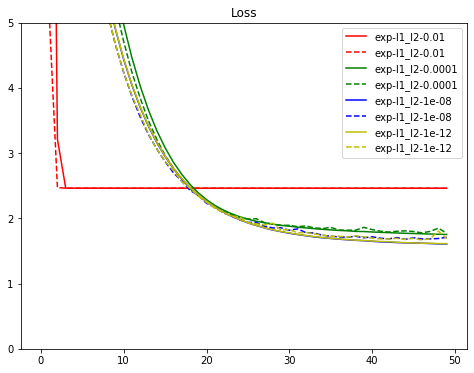

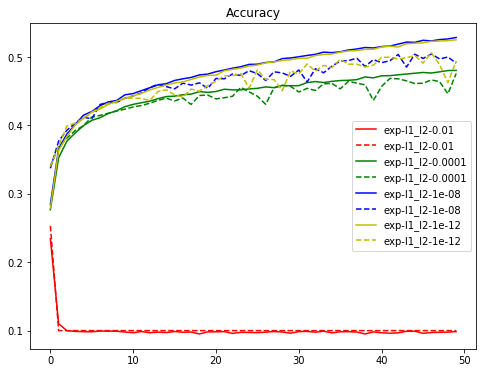

In [14]:
train, test = keras.datasets.cifar10.load_data()




## 資料前處理
def preproc_x(x, flatten=True):
    x = x / 255.
    if flatten:
        x = x.reshape((len(x), -1))
    return x

def preproc_y(y, num_classes=10):
    if y.shape[-1] == 1:
        y = keras.utils.to_categorical(y, num_classes)
    return y   




x_train, y_train = train
x_test, y_test = test

# Preproc the inputs
x_train = preproc_x(x_train)
x_test = preproc_x(x_test)

# Preprc the outputs
y_train = preproc_y(y_train)
y_test = preproc_y(y_test)




# from keras import regularizers
from keras.regularizers import l1, l2, l1_l2

"""
建立神經網路，並加入 L1 或 L2
"""
def build_mlp(input_shape, output_units=10, num_neurons=[512, 256, 128], l1_l2_ratio=1e-4):
    
    input_layer = keras.layers.Input(input_shape)
    
    for i, n_units in enumerate(num_neurons):
        if i == 0:
            x = keras.layers.Dense(units=n_units, 
                                   activation="relu", 
                                   name="hidden_layer"+str(i+1), 
                                   kernel_regularizer=l1_l2(l1_l2_ratio))(input_layer) # regularization
        else:
            x = keras.layers.Dense(units=n_units, 
                                   activation="relu", 
                                   name="hidden_layer"+str(i+1),
                                   kernel_regularizer=l1_l2(l1_l2_ratio))(x) # regularization
    
    out = keras.layers.Dense(units=output_units, activation="softmax", name="output")(x)
    
    model = keras.models.Model(inputs=[input_layer], outputs=[out])
    return model




## 超參數設定
LEARNING_RATE = 1e-3
EPOCHS = 50
BATCH_SIZE = 256
MOMENTUM = 0.95
L1_L2_EXP = [1e-2, 1e-4, 1e-8, 1e-12]




results = {}
"""
使用迴圈建立不同的帶不同 L1/L2 的模型並訓練
"""
for regulizer_ratio in L1_L2_EXP:
    keras.backend.clear_session() # 把舊的 Graph 清掉
    print("Experiment with Regulizer = %.6f" % (regulizer_ratio))
    model = build_mlp(input_shape=x_train.shape[1:], l1_l2_ratio=regulizer_ratio)
    model.summary()
    optimizer = keras.optimizers.SGD(lr=LEARNING_RATE, nesterov=True, momentum=MOMENTUM)
    model.compile(loss="categorical_crossentropy", metrics=["accuracy"], optimizer=optimizer)

    model.fit(x_train, y_train, 
              epochs=EPOCHS, 
              batch_size=BATCH_SIZE, 
              validation_data=(x_test, y_test), 
              shuffle=True)
    
    # Collect results
    train_loss = model.history.history["loss"]
    valid_loss = model.history.history["val_loss"]
    train_acc = model.history.history["acc"]
    valid_acc = model.history.history["val_acc"]
    
    exp_name_tag = "exp-l1_l2-%s" % str(regulizer_ratio)
    results[exp_name_tag] = {'train-loss': train_loss,
                             'valid-loss': valid_loss,
                             'train-acc': train_acc,
                             'valid-acc': valid_acc}
    
    

import matplotlib.pyplot as plt
%matplotlib inline
color_bar = ["r", "g", "b", "y", "m", "k"]

plt.figure(figsize=(8,6))
for i, cond in enumerate(results.keys()):
    plt.plot(range(len(results[cond]['train-loss'])),results[cond]['train-loss'], '-', label=cond, color=color_bar[i])
    plt.plot(range(len(results[cond]['valid-loss'])),results[cond]['valid-loss'], '--', label=cond, color=color_bar[i])
plt.title("Loss")
plt.ylim([0, 5])
plt.legend()
plt.show()

plt.figure(figsize=(8,6))
for i, cond in enumerate(results.keys()):
    plt.plot(range(len(results[cond]['train-acc'])),results[cond]['train-acc'], '-', label=cond, color=color_bar[i])
    plt.plot(range(len(results[cond]['valid-acc'])),results[cond]['valid-acc'], '--', label=cond, color=color_bar[i])
plt.title("Accuracy")
plt.legend()
plt.show()

## 參考資料


Towards Data Science - Regularization in Machine Learning

在前面機器學習的課程中，已經提過 L1 與 L2 的原理與效果。

在深度學習模型中，Regularization 的參數是加在每一個 layer 中，最後在計算 loss 時，才會全部加起來併入 loss term。然而，實務經驗上，目前已經有很多更好避免參數權重過大導致神經網路不穩的方法如BatchNorm，在後面的課程中會陸續提到。

![img1](https://ai100-fileentity.cupoy.com/2nd/homework/D81/1563173943225/large)


## 參考連結：

## [Toward Data Science-Regularization in Machine Learning](https://towardsdatascience.com/regularization-in-machine-learning-76441ddcf99a)

## [Machine Learning Explained: Regularization](http://enhancedatascience.com/2017/07/04/machine-learning-explained-regularization/)

## [機器學習：正規化 by Murphy](https://murphymind.blogspot.com/2017/05/machine.learning.regularization.html)

